### Importing Libraries

In [1]:
from llama_index.core.query_pipeline import QueryPipeline
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core import PromptTemplate
from llama_index.core import (
    VectorStoreIndex,
    ServiceContext,
    SimpleDirectoryReader,
    load_index_from_storage,
    set_global_service_context,
     get_response_synthesizer,
    StorageContext
)
from llama_index.core.response_synthesizers import TreeSummarize
from llama_index.core.query_pipeline import InputComponent
from llama_index.core.retrievers import VectorIndexRetriever
import json

In [2]:
from llama_index.core.postprocessor import SimilarityPostprocessor
import os
from llama_index.llms.gemini import Gemini
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from getpass import getpass
from llama_parse import LlamaParse
import numpy as np
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import Settings
from llama_index.core import StorageContext, load_index_from_storage

In [3]:
import nest_asyncio 
nest_asyncio.apply()

### Getting API key of Gemini

In [75]:
GOOGLE_API_KEY = getpass('Enter the secret value for Google Key: ')
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

Enter the secret value for Google Key: ········


In [76]:
llm = Gemini(temperature=0)

### For PDF Documents Parsing through Llamaparser

In [6]:
parser = LlamaParse(
    api_key="llx-55Ahy15Ur362VmOxdFb6dOWkGPz1Ar1cVyiUtSTyDDXiNqyf",  
    result_type="text",  # "markdown" and "text" are available
    verbose=True,
)

In [9]:
file_extractor = {".pdf": parser}
pdfdocuments = SimpleDirectoryReader(r"C:\Users\Shaikh.Hammad\MS-Thesis\Data", file_extractor=file_extractor).load_data()

Started parsing the file under job_id b6d807a0-55d8-4731-9b56-499b432db499
Started parsing the file under job_id 0db47b1f-f754-42d9-8c89-c638d170a5ae
Started parsing the file under job_id fde2e504-e8a5-4e11-a9c0-d178aee14e84
Started parsing the file under job_id 903efd3f-bce8-4dd6-9267-d606a0734e50
Started parsing the file under job_id 7394720e-0563-452f-a774-e0405871191e
Started parsing the file under job_id 8e0df6ff-aa3d-4a9e-8373-335ffca886b8
Started parsing the file under job_id 24145a77-79a2-4926-99de-70a0741d5777
Started parsing the file under job_id ae75e178-ec98-4250-a8c7-1355db1a6e69
Started parsing the file under job_id 545b3af9-ff9e-44fd-b0b0-2b6d94ecb619
Started parsing the file under job_id ba457325-cb49-47c3-903f-d63bc27efbc1
Started parsing the file under job_id 4e82c1ca-413e-44e2-a107-1f63270f239b
Started parsing the file under job_id c165697e-2223-4edc-8c05-fe712b3e345c
Started parsing the file under job_id abc4ecf4-11cf-4127-aa79-aa0dabd14ca1
Started parsing the file 

In [10]:
pdfdocuments

[Document(id_='2f477e03-e237-4bca-9e23-514ec55cdc1d', embedding=None, metadata={'file_path': 'C:\\Users\\Shaikh.Hammad\\MS-Thesis\\Data\\Brainchild Ramazan 2023 POV - March 2023 - Sent.pdf', 'file_name': 'Brainchild Ramazan 2023 POV - March 2023 - Sent.pdf', 'file_type': 'application/pdf', 'file_size': 586628, 'creation_date': '2024-04-01', 'last_modified_date': '2024-04-01'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text='                     Brainchild\nBrainchild\n            Ramazan 2023 - IMPACT ON MEDIA\n                       March 2023', mimetype='text/plain', start_char_idx=None, end_char_idx=None, metadata_seperator='\n', text_template='{metadata_str}\n\n{content}'),
 Document(id_='2

In [15]:
# storage_context = StorageContext.from_defaults(persist_dir="./storage")
# index = load_index_from_storage(
#     storage_context=storage_context
# )

ValueError: 
******
Could not load OpenAI embedding model. If you intended to use OpenAI, please check your OPENAI_API_KEY.
Original error:
No API key found for OpenAI.
Please set either the OPENAI_API_KEY environment variable or openai.api_key prior to initialization.
API keys can be found or created at https://platform.openai.com/account/api-keys

Consider using embed_model='local'.
Visit our documentation for more embedding options: https://docs.llamaindex.ai/en/stable/module_guides/models/embeddings.html#modules
******

### Embedding the PDFs Data

In [11]:
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

In [12]:
parser = SentenceSplitter(chunk_size=1024)
nodes = parser.get_nodes_from_documents(pdfdocuments)

In [13]:
for idx, node in enumerate(nodes):
    node.id_ = f"node_{idx}"

In [14]:
Settings.embed_model = embed_model
Settings.llm = llm

In [15]:
index = VectorStoreIndex(
    nodes, embed_model = embed_model, 
)

In [24]:
index.storage_context.persist()

In [16]:
retriever = VectorIndexRetriever(
    index=index,
)

In [17]:
response_synthesizer = get_response_synthesizer(
    response_mode="tree_summarize",
)

### Query Pipeline Setup

In [18]:
query_engine = RetrieverQueryEngine(
    retriever=retriever,
    response_synthesizer=response_synthesizer,
)

In [106]:
response = query_engine.query("What are the PSL spends over the years like what are the spends in 2024, 2023 2022 and so on?")
print(response)

The provided text gives the PSL 2024 spend as 4.16 Billion, but does not offer spending figures for previous years.



In [34]:
retrieved_docs = retriever.retrieve('What is the expected trend in television viewership during Ramazan 2023 compared to the previous year?')
for node_with_score in retrieved_docs:
  print(node_with_score)

Node ID: node_1
Text: SYNOPSIS RAMAZAN IMPACT ON MEDIA INDUSTRY The upcoming Ramazan
season is poised to be significantly distinct from prior years due to
a sharp rise in inflation and a highly unstable political climate. The
current state of affairs, compounded by a considerably low Consumer
Confidence Index (CCI), has left consumers uneasy about what lies
ahead.   ...
Score:  0.844

Node ID: node_2
Text: RAMAZAN LANDSCAPE      As Ramazan approaches, Pakistan continues
to grapple with economic challenges and political volatility. Record
rise in inflation to 31.5% in February 2023 along with the impending
IMF decision and historically low Consumer      Confidence Index
levels are expected to alter consumer behaviour during this year's
Ramazan...
Score:  0.843



### Evaluation

In [21]:
from llama_index.core.evaluation import (
    generate_question_context_pairs,
    EmbeddingQAFinetuneDataset,
)

In [22]:
file_path = r"C:\Users\Shaikh.Hammad\MS-Thesis\msthesis_venv_V1\pg_eval_dataset_final.json"
with open(file_path, "r", encoding="utf-8") as json_file:
    qa_dataset = json.load(json_file)

In [23]:
qa_dataset

{'queries': {'f8bcaa86-88a5-4a29-b5b5-d7853171372a': 'How might the unstable political climate and low Consumer Confidence Index (CCI) impact television viewership during Ramazan 2023? Explain your reasoning.',
  '701c22dd-b823-4ba2-8507-44584954b7a5': 'What was the percentage change in Ramazan AdEx in 2022 compared to 2021?',
  '6e06926d-81e7-41b1-9fec-027f71f1c1b0': 'What is the expected trend in television viewership during Ramazan 2023 compared to the previous year?',
  '50734e6f-8b61-4b2d-8aa0-72f0477a356e': "Imagine you are a marketing manager for a food delivery app. How could you leverage the trends in recipe searches and grocery shopping during Ramadan to increase your app's usage?",
  'cd77fd88-21e7-48df-aa67-53bd77a2c071': "What percentage of Pakistan's population is expected to be gamers by 2026?",
  '0e633c5d-1e05-4fb2-8e34-11ac854bd095': 'Based on the information provided, what is one potential way that GPT-4 could revolutionize the way work is done in the marketing indus

In [24]:
from llama_index.core.evaluation import RetrieverEvaluator

metrics = ["hit_rate", "mrr", "precision", "recall", "ap", "ndcg"]

In [25]:
retriever_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=retriever
)

In [26]:
first_query_id = next(iter(qa_dataset["queries"]))  # Get the first key in queries
first_query = qa_dataset["queries"][first_query_id]

# Extract the first corpus
first_corpus_id = next(iter(qa_dataset["corpus"]))  # Get the first key in corpus
first_corpus = qa_dataset["corpus"][first_corpus_id]

# Extract the first relevant doc
first_relevant_doc_id = next(iter(qa_dataset["relevant_docs"]))  # Get the first key in relevant_docs
first_relevant_doc = qa_dataset["relevant_docs"][first_relevant_doc_id][0]  # Get the first document id


In [27]:
print(first_query)
print(first_query_id)
print(first_relevant_doc)

How might the unstable political climate and low Consumer Confidence Index (CCI) impact television viewership during Ramazan 2023? Explain your reasoning.
f8bcaa86-88a5-4a29-b5b5-d7853171372a
node_1


In [28]:
eval_result = retriever_evaluator.evaluate(first_query, [first_relevant_doc])
print(eval_result)

Query: How might the unstable political climate and low Consumer Confidence Index (CCI) impact television viewership during Ramazan 2023? Explain your reasoning.
Metrics: {'hit_rate': 1.0, 'mrr': 1.0, 'precision': 0.5, 'recall': 1.0, 'ap': 1.0, 'ndcg': 0.6131471927654584}



In [29]:
for query_id, query in qa_dataset['queries'].items():
    relevant_docs = qa_dataset["relevant_docs"].get(query_id, [])
    eval_result = retriever_evaluator.evaluate(query, relevant_docs)
    print(eval_result)

Query: How might the unstable political climate and low Consumer Confidence Index (CCI) impact television viewership during Ramazan 2023? Explain your reasoning.
Metrics: {'hit_rate': 1.0, 'mrr': 1.0, 'precision': 0.5, 'recall': 1.0, 'ap': 1.0, 'ndcg': 0.6131471927654584}

Query: What was the percentage change in Ramazan AdEx in 2022 compared to 2021?
Metrics: {'hit_rate': 1.0, 'mrr': 1.0, 'precision': 0.5, 'recall': 1.0, 'ap': 1.0, 'ndcg': 0.6131471927654584}

Query: What is the expected trend in television viewership during Ramazan 2023 compared to the previous year?
Metrics: {'hit_rate': 0.0, 'mrr': 0.0, 'precision': 0.0, 'recall': 0.0, 'ap': 0.0, 'ndcg': 0.0}

Query: Imagine you are a marketing manager for a food delivery app. How could you leverage the trends in recipe searches and grocery shopping during Ramadan to increase your app's usage?
Metrics: {'hit_rate': 0.0, 'mrr': 0.0, 'precision': 0.0, 'recall': 0.0, 'ap': 0.0, 'ndcg': 0.0}

Query: What percentage of Pakistan's popula

In [35]:
qa_dataset = EmbeddingQAFinetuneDataset.from_json(r"C:\Users\Shaikh.Hammad\MS-Thesis\msthesis_venv_V1\pg_eval_dataset_final.json")

In [80]:
eval_results = await retriever_evaluator.aevaluate_dataset(qa_dataset)

In [81]:
import pandas as pd


def display_results(name, eval_results):
    """Display results from evaluate."""

    metric_dicts = []
    for eval_result in eval_results:
        metric_dict = eval_result.metric_vals_dict
        metric_dicts.append(metric_dict)

    full_df = pd.DataFrame(metric_dicts)

    columns = {
        "retrievers": [name],
        **{k: [full_df[k].mean()] for k in metrics},
    }

    metric_df = pd.DataFrame(columns)

    return metric_df

In [82]:
display_results("Dataset evaluation", eval_results)

,retrievers,hit_rate,mrr,precision,recall,ap,ndcg
0,Dataset evaluation,0.625,0.583333,0.3125,0.625,0.583333,0.364359


In [141]:
display_results("Dataset evaluation", eval_results)

,retrievers,hit_rate,mrr,precision,recall,ap,ndcg
0,Dataset evaluation,0.75,0.666667,0.375,0.75,0.666667,0.422145


### Hybrid Retriever (BM25+Vector Retriever)

In [66]:
from llama_index.core.tools import RetrieverTool
from llama_index.retrievers.bm25 import BM25Retriever

In [67]:
bm25_retriever = BM25Retriever.from_defaults(nodes=nodes)

In [68]:
retriever_tools = [
    RetrieverTool.from_defaults(
        retriever=retriever,
        description="Useful in most cases",
    ),
    RetrieverTool.from_defaults(
        retriever=bm25_retriever,
        description="Useful if searching about specific information",
    ),
]

In [69]:
from llama_index.core.retrievers import RouterRetriever

hybrid_retriever = RouterRetriever.from_defaults(
    retriever_tools=retriever_tools,
    llm=llm,
    select_multi=True,
)

In [70]:
query_engine = RetrieverQueryEngine(
    retriever=hybrid_retriever,
    response_synthesizer=response_synthesizer,
)

In [105]:
response = query_engine.query("What are the PSL spends over the years like what are the spends in 2024, 2023 2022 and so on?")
print(response)

The provided text gives the PSL 2024 spend as 4.16 Billion, but does not offer spending figures for previous years.



In [72]:
retriever_evaluator_hybrid = RetrieverEvaluator.from_metric_names(
    metrics, retriever=hybrid_retriever
)

In [77]:
eval_results_hybrid = await retriever_evaluator_hybrid.aevaluate_dataset(qa_dataset)

In [78]:
import pandas as pd


def display_results(name, eval_results):
    """Display results from evaluate."""

    metric_dicts = []
    for eval_result in eval_results:
        metric_dict = eval_result.metric_vals_dict
        metric_dicts.append(metric_dict)

    full_df = pd.DataFrame(metric_dicts)

    columns = {
        "retrievers": [name],
        **{k: [full_df[k].mean()] for k in metrics},
    }

    metric_df = pd.DataFrame(columns)

    return metric_df

In [79]:
display_results("Dataset evaluation", eval_results_hybrid)

,retrievers,hit_rate,mrr,precision,recall,ap,ndcg
0,Dataset evaluation,0.708333,0.604167,0.354167,0.708333,0.604167,0.387168


In [121]:
display_results("Dataset evaluation", eval_results_hybrid)

,retrievers,hit_rate,mrr,precision,recall,ap,ndcg
0,Dataset evaluation,0.833333,0.722222,0.40625,0.833333,0.722222,0.455825


### Hybrid Reteriever with reranking

In [160]:
QUERY_GEN_PROMPT = (
    "You are a helpful assistant that generates multiple search queries based on a "
    "single input query. Generate {num_queries} search queries, one on each line, "
    "related to the following input query:\n"
    "Query: {query}\n"
    "Queries:\n"
)

In [161]:
from llama_index.core.retrievers import QueryFusionRetriever

hybrid_fusion_retriever = QueryFusionRetriever(
    [retriever, bm25_retriever],
    num_queries=1,  # set this to 1 to disable query generation
    mode="reciprocal_rerank",
    use_async=True,
    verbose=True,
#     query_gen_prompt=QUERY_GEN_PROMPT,  # we could override the query generation prompt here
)

In [162]:
query_engine = RetrieverQueryEngine(
    retriever=hybrid_fusion_retriever,
    response_synthesizer=response_synthesizer,
)

In [163]:
response = query_engine.query('How might the unstable political climate and low Consumer Confidence Index (CCI) impact television viewership during Ramazan 2023? Explain your reasoning')

In [164]:
from llama_index.core.response.notebook_utils import display_response

display_response(response)

**`Final Response:`** The unstable political climate is expected to affect television viewership during Ramazan 2023, potentially mirroring the impact seen in 2022.  The low CCI adds to this uncertainty, suggesting that consumer behavior may be unpredictable.

In [165]:
retriever_evaluator_hybrid = RetrieverEvaluator.from_metric_names(
    metrics, retriever=hybrid_retriever
)

In [212]:
import asyncio

async def evaluate_with_resume(retriever, dataset, retries=3, delay=60):
    """
    Evaluate a dataset with retry logic and the ability to resume from where it left off.

    Args:
        retriever: The retriever object with the `aaevaluate_dataset` method.
        dataset: The dataset to evaluate.
        retries: Number of retry attempts.
        delay: Time to wait (in seconds) between retries.

    Returns:
        List of evaluation results.

    Raises:
        RuntimeError: If all retries are exhausted.
    """
    completed_results = []
    remaining_dataset = dataset  # Start with the full dataset

    for attempt in range(retries):
        try:
            # Evaluate the remaining part of the dataset
            results = await retriever.aevaluate_dataset(remaining_dataset)
            completed_results.extend(results)  # Append results to completed
            return completed_results  # Return completed results if successful
        except Exception as e:
            if "429" in str(e):
                print(f"Rate limit error on attempt {attempt + 1}: {e}. Retrying in {delay} seconds...")
                await asyncio.sleep(delay)  # Wait before retrying
            else:
                raise  # Raise other exceptions immediately
        finally:
            # Update remaining dataset by excluding already processed items
            processed_count = len(completed_results)
            remaining_dataset = dataset[processed_count:]  # Skip already processed

    raise RuntimeError("Maximum retry attempts reached.")


In [217]:
eval_results_hybrid = await retriever_evaluator_hybrid.aevaluate_dataset(qa_dataset)

INFO:llama_index.core.retrievers.router_retriever:Selecting retriever 1: The question asks for a specific impact (on television viewership during Ramazan 2023) in relation to specific factors (unstable political climate and low CCI).  Therefore, a search for specific information is required to answer it..
Selecting retriever 1: The question asks for a specific impact (on television viewership during Ramazan 2023) in relation to specific factors (unstable political climate and low CCI).  Therefore, a search for specific information is required to answer it..
INFO:llama_index.core.retrievers.router_retriever:Selecting retriever 1: The question asks for a specific piece of information (percentage change in Ramazan AdEx between two specific years)..
Selecting retriever 1: The question asks for a specific piece of information (percentage change in Ramazan AdEx between two specific years)..
INFO:llama_index.core.retrievers.router_retriever:Selecting retriever 1: The question seeks specific i

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:llama_index.core.retrievers.router_retriever:Selecting retriever 1: The question requires specific information about viewership during Prime Time versus Non-Prime Time, and the reasons for differences.  A general summary would not be sufficient..
Selecting retriever 1: The question requires specific information about viewership during Prime Time versus Non-Prime Time, and the reasons for differences.  A general summary would not be sufficient..
INFO:llama_index.core.retrievers.router_retriever:Selecting retriever 1: The question asks for specific information about the differences in impact of political instability on TV viewership between major cities and non-metro areas.  This requires a focused search for specific data..
Selecting retriever 1: The question asks for specific information about the differences in impact of political instability on TV viewership between major cities and non-metro areas.  This requires a focused search for specific data..
INFO:llama_index.core.retrie

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ResourceExhausted: 429 Resource has been exhausted (e.g. check quota).

In [ ]:
import pandas as pd


def display_results(name, eval_results):
    """Display results from evaluate."""

    metric_dicts = []
    for eval_result in eval_results:
        metric_dict = eval_result.metric_vals_dict
        metric_dicts.append(metric_dict)

    full_df = pd.DataFrame(metric_dicts)

    columns = {
        "retrievers": [name],
        **{k: [full_df[k].mean()] for k in metrics},
    }

    metric_df = pd.DataFrame(columns)

    return metric_df

In [ ]:
display_results("Dataset evaluation", eval_results_hybrid)

### For Structured data (Excel)

In [172]:
from llama_index.core.query_pipeline import (
    QueryPipeline as QP,
    Link,
    InputComponent,
)
from llama_index.core.query_engine.pandas import PandasInstructionParser
from llama_index.core.prompts import PromptTemplate
import pandas as pd
from llama_index.experimental.query_engine.pandas import PandasInstructionParser

In [182]:
df =pd.read_excel(r'C:\Users\Shaikh.Hammad\Data\Industry Summary\2023\Industry summary Jan to Dec 2023.xlsx')

In [183]:
df

,AgencyName,Advertiser,Granular AgencyName,Year,Weekday,Category,subcategory,brand,Adtype,month,...,Hour,Daypart,Genre,DA MV CAL,Net_Spend,Minute,Frequency,Individuals,Individuals_Norm,Channel Group
0,GroupM,1 Link,MediaCom,2023,Weekday,Financial Services,Financial Traders,PayPak Card,Spot/TVC,December,...,20,Prime,Entertainment,343400.000000,309060.000000,1.700000,7,6.147,2.982067,Green Network
1,GroupM,1 Link,MediaCom,2023,Weekday,Financial Services,Financial Traders,PayPak Card,Spot/TVC,December,...,19,Prime,Entertainment,133300.000000,119970.000000,2.150000,3,2.191,3.140433,Green Network
2,GroupM,1 Link,MediaCom,2023,Weekday,Financial Services,Financial Traders,PayPak Card,Spot/TVC,December,...,16,Afternoon,Entertainment,58666.666667,52800.000000,5.866667,23,5.246,2.575400,Green Network
3,GroupM,1 Link,MediaCom,2023,Weekday,Financial Services,Financial Traders,PayPak Card,Spot/TVC,December,...,12,Morning,Entertainment,56000.000000,50400.000000,5.600000,24,6.508,3.037067,Green Network
4,GroupM,1 Link,MediaCom,2023,Weekday,Financial Services,Financial Traders,PayPak Card,Spot/TVC,December,...,14,Afternoon,Entertainment,44333.333333,39900.000000,4.433333,19,4.800,2.240000,Green Network
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909381,GroupM,Tapal Tea,MediaCom,2023,Weekend,Beverages,Tea,Tapal Danedar Tea,Spot/TVC,September,...,19,Prime,News,45833.333333,18333.333333,9.166667,55,4.642,1.547333,gtv network
909382,GroupM,Tapal Tea,MediaCom,2023,Weekend,Beverages,Tea,Tapal Danedar Tea,Spot/TVC,September,...,20,Prime,News,24166.666667,9666.666667,4.833333,29,0.875,0.291667,gtv network
909383,GroupM,Tapal Tea,MediaCom,2023,Weekend,Beverages,Tea,Tapal Danedar Tea,Spot/TVC,September,...,21,Prime,News,45000.000000,18000.000000,9.000000,54,6.086,2.028667,gtv network
909384,GroupM,Tapal Tea,MediaCom,2023,Weekend,Beverages,Tea,Tapal Danedar Tea,Spot/TVC,September,...,22,Post Prime,News,79879.500000,31951.800000,10.166667,61,5.565,1.855000,gtv network


In [184]:

instruction_str = (
    "1. Convert the query to executable Python code using Pandas.\n"
    "2. Use fuzzy string matching or regular expressions to identify similar or matching brand names and advertiser names in the dataframe.\n"
    "3. Ensure that the code handles variations in brand names and advertiser names, such as different spellings or formats.\n"
    "4. The final line of code should be a Python expression that can be called with the `eval()` function.\n"
    "5. PRINT ONLY THE EXPRESSION.\n"
    "6. Do not quote the expression.\n"
    "\n"
)

pandas_prompt_str = (
    "You are working with a pandas dataframe in Python.\n"
    "The name of the dataframe is `df`.\n"
    "This is the result of `print(df.head())`:\n"
    "{df_str}\n\n"
    "Follow these instructions:\n"
    "{instruction_str}\n"
    "Query: {query_str}\n\n"
    "Expression:"
)
response_synthesis_prompt_str = (
    "Given an input question, synthesize a response from the query results. The unit of measure of spend is PKR.\n"
    "Query: {query_str}\n\n"
    "Pandas Instructions (optional):\n{pandas_instructions}\n\n"
    "Pandas Output: {pandas_output}\n\n"
    "Response: "
)

pandas_prompt = PromptTemplate(pandas_prompt_str).partial_format(
    instruction_str=instruction_str, df_str=df
)
pandas_output_parser = PandasInstructionParser(df)
response_synthesis_prompt = PromptTemplate(response_synthesis_prompt_str)
llm = Gemini(temperature=0)

### Query Pipeline Setup

In [185]:
qp = QP(
    modules={
        "input": InputComponent(),
        "pandas_prompt": pandas_prompt,
        "llm1": llm,
        "pandas_output_parser": pandas_output_parser,
        "response_synthesis_prompt": response_synthesis_prompt,
        "llm2": llm,
    },
    verbose=True,
)
qp.add_chain(["input", "pandas_prompt", "llm1", "pandas_output_parser"])
qp.add_links(
    [
        Link("input", "response_synthesis_prompt", dest_key="query_str"),
        Link(
            "llm1", "response_synthesis_prompt", dest_key="pandas_instructions"
        ),
        Link(
            "pandas_output_parser",
            "response_synthesis_prompt",
            dest_key="pandas_output",
        ),
    ]
)
# add link from response synthesis prompt to llm2
qp.add_link("response_synthesis_prompt", "llm2")

In [190]:
response = qp.run(
    query_str="What are the channel wise spends of the advertiser Nestle for the 2023, provide only top 10 and use channel column dont use channel group?",
)

> Running module input with input: 
query_str: What are the channel wise spends of the advertiser Nestle for the 2023, provide only top 10 and use channel column dont use channel group?

> Running module pandas_prompt with input: 
query_str: What are the channel wise spends of the advertiser Nestle for the 2023, provide only top 10 and use channel column dont use channel group?

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`.
This is the result of `print(df.head())`:
       AgencyName Advertiser Granular AgencyName  Year  Weekday  \
0    ...

> Running module pandas_output_parser with input: 
input: assistant: df.loc[df['Advertiser'].str.contains('Nestle', case=False, na=False) & (df['Year'] == 2023), ['Channel Group', 'Net_Spend']].groupby('Channel Group').sum().sort_values('Net_Spend', ascendin...

> Running module response_synthesis_prompt with input: 
query_str: What are the channel wise spends of th

In [191]:
print(response.message.content)

Nestle's top 10 channels in 2023, ranked by spend (in PKR), are:

1. Geo Network: 566,140,700 PKR
2. ARY Network: 401,181,700 PKR
3. PTV Network: 334,493,300 PKR
4. Express Network: 216,180,500 PKR
5. Hum Network: 173,183,600 PKR
6. Air Waves Media: 119,305,200 PKR
7. Green Network: 96,089,010 PKR
8. 24-Seven Media Networks: 62,259,440 PKR
9. AAN TV (Pvt.) Limited: 53,445,620 PKR
10. Sports Star International: 45,442,830 PKR



##### miscellaneous Coding

In [ ]:
import json
import os
import time
from tqdm import tqdm

output_folder = "pg_eval_dataset"
os.makedirs(output_folder, exist_ok=True)

wait_time = 5  
max_retries = 3

for index, node in enumerate(tqdm(nodes, desc="Generating QA pairs")):
    retries = 0
    success = False

    while not success and retries < max_retries:
        try:
            qa_pair = generate_question_context_pairs(
                [node],  # Process one node at a time
                llm=llm,
                num_questions_per_chunk=5
            )

            # Convert the QA pair to a dictionary or serializable format if needed
            if hasattr(qa_pair, 'to_dict'):
                qa_pair_dict = qa_pair.to_dict()
            elif hasattr(qa_pair, 'json'):
                qa_pair_dict = json.loads(qa_pair.json())  # Assuming it has a `.json()` method
            else:
                # If it's already a dictionary or list, assign it directly
                qa_pair_dict = qa_pair if isinstance(qa_pair, (dict, list)) else {}

            # Save the QA pair to a JSON file with a unique name based on index
            qa_filename = os.path.join(output_folder, f"pg_eval_dataset_{index}.json")
            with open(qa_filename, "w", encoding="utf-8") as json_file:
                json.dump(qa_pair_dict, json_file, indent=4)

            print(f"Saved QA pair {index} to {qa_filename}")
            success = True

            # Wait before processing the next node to avoid rate limit issues
            time.sleep(wait_time)

        except Exception as e:
            # If a 429 error occurs, increase the wait time and retry
            retries += 1
            print(f"Failed to process node {index} due to {e}. Retrying {retries}/{max_retries}...")

            # Increase wait time on each retry to avoid rapid retries
            time.sleep(wait_time * retries)

    if not success:
        print(f"Max retries reached for node {index}. Skipping to next node.")

# Save all QA pairs collectively if needed
qa_dataset = {"qa_pairs": all_qa_pairs}
with open(os.path.join(output_folder, "qa_dataset_all.json"), "w", encoding="utf-8") as json_file:
    json.dump(qa_dataset, json_file, indent=4)

print("All QA pairs generated and saved successfully.")


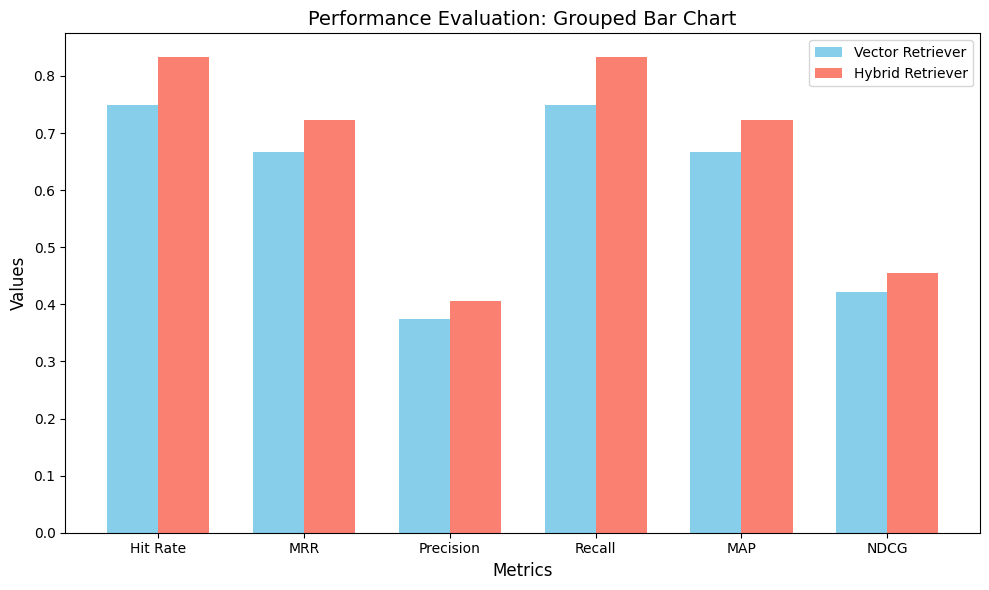

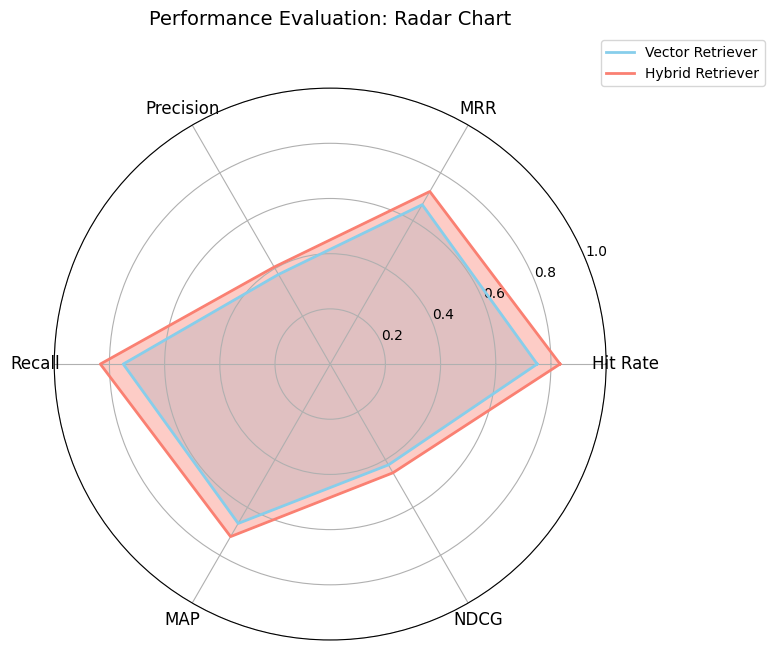

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Data
metrics = ["Hit Rate", "MRR", "Precision", "Recall", "MAP", "NDCG"]
vector_retriever = [0.75, 0.667, 0.375, 0.75, 0.667, 0.422]
hybrid_retriever = [0.833, 0.722, 0.406, 0.833, 0.722, 0.455]

# Grouped Bar Chart
x = np.arange(len(metrics))  # Metric indices
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width / 2, vector_retriever, width, label='Vector Retriever', color='skyblue')
ax.bar(x + width / 2, hybrid_retriever, width, label='Hybrid Retriever', color='salmon')

# Customize the bar chart
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Values', fontsize=12)
ax.set_title('Performance Evaluation: Grouped Bar Chart', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=10)
ax.legend()

plt.tight_layout()
plt.show()

# Radar Chart
from math import pi

# Radar chart setup
labels = metrics
num_vars = len(labels)

angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Append first value to close the circle
vector_retriever += vector_retriever[:1]
hybrid_retriever += hybrid_retriever[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot data
ax.plot(angles, vector_retriever, linewidth=2, linestyle='solid', label='Vector Retriever', color='skyblue')
ax.fill(angles, vector_retriever, alpha=0.4, color='skyblue')

ax.plot(angles, hybrid_retriever, linewidth=2, linestyle='solid', label='Hybrid Retriever', color='salmon')
ax.fill(angles, hybrid_retriever, alpha=0.4, color='salmon')

# Customize radar chart
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=10)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)

ax.set_title('Performance Evaluation: Radar Chart', fontsize=14, y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()
